In [10]:
import torch
from models import Showo, MAGVITv2
from training.prompting_utils import UniversalPrompting, create_attention_mask_for_mmu, create_attention_mask_for_mmu_vit
from training.utils import get_config, flatten_omega_conf, image_transform
from transformers import AutoTokenizer
from models.clip_encoder import CLIPVisionTower
from transformers import CLIPImageProcessor
# import training.conversation as conversation_lib
from llava.llava import conversation as conversation_lib

conversation_lib.default_conversation = conversation_lib.conv_templates["phi1.5"]


In [11]:
# config load -  'showo_demo_w_clip_vit.yaml'
from omegaconf import DictConfig, ListConfig, OmegaConf
config = OmegaConf.load('configs/showo_demo_w_clip_vit.yaml')

In [12]:
# device setup
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [13]:

# show o tokenizer setup and adding special tokens to universal prompting
# llm model : 'microsoft/phi-1_5'
tokenizer = AutoTokenizer.from_pretrained(config.model.showo.llm_model_path, padding_side ="left")
uni_prompting = UniversalPrompting(tokenizer, max_text_len=config.dataset.preprocessing.max_seq_length,
                                       special_tokens=("<|soi|>", "<|eoi|>", "<|sov|>", "<|eov|>", "<|t2i|>", "<|mmu|>", "<|t2v|>", "<|v2v|>", "<|lvg|>"),
                                       ignore_id=-100, cond_dropout_prob=config.training.cond_dropout_prob)


In [14]:
# setting up the visual question answering model: magvit-v2
vq_model = MAGVITv2
vq_model = vq_model.from_pretrained(config.model.vq_model.vq_model_name).to(device)
vq_model.requires_grad_(False)
vq_model.eval()

Working with z of shape (1, 13, 16, 16) = 3328 dimensions.
Look-up free quantizer with codebook size: 8192


MAGVITv2(
  (encoder): VQGANEncoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-3): 4 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

In [15]:
# setting up vision tower: clip-vit
vision_tower_name ="openai/clip-vit-large-patch14-336"
vision_tower = CLIPVisionTower(vision_tower_name).to(device)
clip_image_processor = CLIPImageProcessor.from_pretrained(vision_tower_name)


/home/vasilevpa/Show-o/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
# setting up the showo model 
model = Showo.from_pretrained(config.model.showo.pretrained_model_path).to(device)
model.eval()

The config attributes {'mask_token_id': 58497} were passed to Showo, but are not expected and will be ignored. Please verify your config.json configuration file.


attention implementation:  sdpa


/home/vasilevpa/Show-o/models/modeling_showo.py:49: FutureWarning: Accessing config attribute `w_clip_vit` directly via 'Showo' object attribute is deprecated. Please access 'w_clip_vit' over 'Showo's config object instead, e.g. 'unet.config.w_clip_vit'.
  if self.w_clip_vit:


Showo(
  (showo): PhiForCausalLM(
    (model): PhiModel(
      (embed_tokens): Embedding(58498, 2048)
      (embed_dropout): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0-23): 24 x PhiDecoderLayer(
          (self_attn): PhiSdpaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (dense): Linear(in_features=2048, out_features=2048, bias=True)
            (q_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (k_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (rotary_emb): PhiRotaryEmbedding()
          )
          (mlp): PhiMLP(
            (activation_fn): NewGELUActivation()
            (fc1): Linear(in_features=2048, out_features=8192, bias=True)
            (fc2): Linear(in_features=8192, out_features=2048, b

In [19]:
# setting up the parameters
temperature = 0.8  # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 1  # retain only the top_k most likely tokens, clamp others to have 0 probability
SYSTEM_PROMPT = "A chat between a curious user and an artificial intelligence assistant. " \
                "The assistant gives helpful, detailed, and polite answers to the user's questions."
SYSTEM_PROMPT_LEN = 28


## Inference 

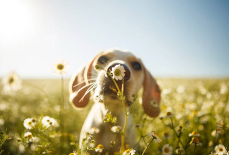

In [22]:
import os
import requests
from IPython.display import Image
from urllib.parse import urlparse

def load_image(path_or_url, save_dir="downloaded_images"):
    """Load image from local path or URL."""
    if os.path.exists(path_or_url):
        return Image(filename=path_or_url)

    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, os.path.basename(urlparse(path_or_url).path))
    
    with requests.get(path_or_url, stream=True) as r:
        if r.status_code == 200:
            with open(filename, "wb") as f:
                for chunk in r.iter_content(1024):
                    f.write(chunk)
            return Image(filename=filename)
    
    print("Failed to load image.")
    return None

# Example usage
image_path_or_url = "mmu_validation/dog.png"  # Or a URL
load_image(image_path_or_url)

In [21]:
# inference
from PIL import Image
## arguments
input_image_path ="./mmu_validation/sofa_under_water.jpg"
questions ='Please describe this image in detail. *** Do you think the image is unusual or not?'

## processing
questions = questions.split('***')
image_ori = Image.open(input_image_path).convert("RGB")
# tranforming the image to the required resolution:256x256
image = image_transform(image_ori, resolution = config.dataset.params.resolution).to(device)
image = image.unsqueeze(0)
print(f"image shape: {image.shape}") # torch.Size([1, 3, 256, 256])
pixel_values = clip_image_processor.preprocess(image_ori,return_tensors="pt")['pixel_values'][0]
print(f"pixel values shape: {pixel_values.shape}")
image_tokens = vq_model.get_code(image) + len(uni_prompting.text_tokenizer)
print(f"image tokens shape: {image_tokens.shape}") # torch.Size([1, 256])
batch_size = 1

## inference
for question in questions: 
  conv = conversation_lib.default_conversation.copy()
  print(f"conversation: {conv}")
  conv.append_message(conv.roles[0], question)
  conv.append_message(conv.roles[1], None)
  prompt_question = conv.get_prompt()
  # print(prompt_question)
  question_input = []
  question_input.append(prompt_question.strip())
  print(f"system prompt: {SYSTEM_PROMPT}")
  input_ids_system = [uni_prompting.text_tokenizer(SYSTEM_PROMPT, return_tensors="pt", padding="longest").input_ids for _ in range(batch_size)]
  print(f"system prompt input ids: {input_ids_system}")
  input_ids_system = torch.stack(input_ids_system, dim=0)
  assert input_ids_system.shape[-1] == 28
  print(f"after torch stacking: {input_ids_system}")
  input_ids_system = input_ids_system.clone().detach().to(device)
  # inputs_ids_system = input_ids_system.to(device)
#   inputs_ids_system = torch.tensor(input_ids_system).to(device).squeeze(0)
  
  print(f"after moving to device: {input_ids_system}")
  input_ids_system = input_ids_system[0]
  print(f"after indexing 0: {input_ids_system}")
  
  
  print(f"question input: {question_input}")
  input_ids = [uni_prompting.text_tokenizer(prompt, return_tensors="pt", padding="longest").input_ids for prompt in question_input]
  print(f"after tokenizing the question: {input_ids}")
  input_ids = torch.stack(input_ids)
  print(f"after torch stacking: {input_ids}")
  input_ids = torch.nn.utils.rnn.pad_sequence(
                        input_ids, batch_first=True, padding_value=uni_prompting.text_tokenizer.pad_token_id
                )
  print(f"after padding: {input_ids}")
  # input_ids = torch.tensor(input_ids).to(device).squeeze(0)
  input_ids = input_ids.clone().detach().to(device).squeeze(0)
  print(f"after moving to device: {input_ids}")
  input_ids_llava = torch.cat([
                          (torch.ones(input_ids.shape[0], 1) *uni_prompting.sptids_dict['<|mmu|>']).to(device),
                          input_ids_system,
                          (torch.ones(input_ids.shape[0], 1) * uni_prompting.sptids_dict['<|soi|>']).to(device),
                          # place your img embedding here
                          (torch.ones(input_ids.shape[0], 1) * uni_prompting.sptids_dict['<|eoi|>']).to(device),
                          input_ids,
                  ], dim=1).long()
  print(input_ids_llava)
  
  images_embeddings = vision_tower(pixel_values[None])
  print(f"images embeddings shape: {images_embeddings.shape}")# torch.Size([1, 576, 1024])
  images_embeddings = model.mm_projector(images_embeddings)
  print(f"images embeddings shape after projection: {images_embeddings.shape}") 

  text_embeddings = model.showo.model.embed_tokens(input_ids_llava)

  #full input seq
  part1 = text_embeddings[:, :2+SYSTEM_PROMPT_LEN,:]
  part2 = text_embeddings[:, 2+SYSTEM_PROMPT_LEN:,:]
  input_embeddings = torch.cat((part1,images_embeddings,part2),dim=1)

  attention_mask_llava = create_attention_mask_for_mmu_vit(input_embeddings,system_prompt_len=SYSTEM_PROMPT_LEN)

  cont_toks_list = model.mmu_generate(
    input_embeddings = input_embeddings,
    attention_mask = attention_mask_llava[0].unsqueeze(0),
    max_new_tokens = 100,
    top_k = top_k,
    eot_token = uni_prompting.sptids_dict['<|eov|>']
  )
  
  cont_toks_list = torch.stack(cont_toks_list).squeeze()[None]
  text = uni_prompting.text_tokenizer.batch_decode(cont_toks_list,skip_special_tokens=True)
  print(f"User: {question}, \nAnswer: {text[0]}")




image shape: torch.Size([1, 3, 256, 256])
pixel values shape: torch.Size([3, 336, 336])
image tokens shape: torch.Size([1, 256])
conversation: Conversation(system='', roles=('USER', 'ASSISTANT'), messages=[], offset=0, sep_style=<SeparatorStyle.TWO: 2>, sep=' ', sep2='<|endoftext|>', version='v0', skip_next=False)
system prompt: A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.
system prompt input ids: [tensor([[   32,  8537,  1022,   257, 11040,  2836,   290,   281, 11666,  4430,
          8796,    13,   383,  8796,  3607,  7613,    11,  6496,    11,   290,
         23507,  7429,   284,   262,  2836,   338,  2683,    13]])]
after torch stacking: tensor([[[   32,  8537,  1022,   257, 11040,  2836,   290,   281, 11666,  4430,
           8796,    13,   383,  8796,  3607,  7613,    11,  6496,    11,   290,
          23507,  7429,   284,   262,  2836,   338,  2683,    13]]])
after movin